### 决策树分类的方式
(1) ID3算法以信息增益为准则来进行选择划分属性，选择信息增益最大的；  
(2) C4.5算法先从候选划分属性中找出信息增益高于平均水平的属性，再从中选择增益率最高的；  
(3) CART算法使用“基尼指数”来选择划分属性，选择基尼值最小的属性作为划分属性.  

数据集说明：  
（0）年龄：0代表青年，1代表中年，2代表老年；  
（1）有工作：0代表否，1代表是；  
（2）有自己的房子：0代表否，1代表是；  
（3）信贷情况：0代表一般，1代表好，2代表非常好；  
（4）类别(是否给贷款)：no代表否，yes代表是。  

写的比较好的一个例子：https://blog.csdn.net/u012328159/article/details/70184415  
代码参考了：https://github.com/Erikfather/Decision_tree-python

In [263]:
import os, sys
import operator
from math import log
import treePlotter

In [264]:
def readTrainData(fileName):
    """
    年龄段：0代表青年，1代表中年，2代表老年；
    有工作：0代表否，1代表是；
    有自己的房子：0代表否，1代表是；
    信贷情况：0代表一般，1代表好，2代表非常好；
    类别(是否给贷款)：0代表否，1代表是
    """
    f = open(fileName, 'r')
    lines = f.readlines()
    # 这里label表示分类属性
    labels = ['age', 'have_work', 'have_house', 'credit']
    dataSet = []
    for line in lines[:]:
        line = line.strip().split(',')
        dataSet.append(line)
    return dataSet, labels

In [265]:
def readTestData(fileName):
    """
    年龄段：0代表青年，1代表中年，2代表老年；
    有工作：0代表否，1代表是；
    有自己的房子：0代表否，1代表是；
    信贷情况：0代表一般，1代表好，2代表非常好；
    类别(是否给贷款)：0代表否，1代表是
    """
    f = open(fileName, 'r')
    lines = f.readlines()
    dataSet = []
    for line in lines[:]:
        line = line.strip().split(',')
        dataSet.append(line)
    return dataSet

In [266]:
def calEntropy(dataMat):
    '''
    计算熵
    gain(D,A) = H(D) - H(D|A)
    这里这个函数是计算H(D)
    '''
    numTrainData = len(dataMat)
    labelCounts = {}
    for featVec in dataMat:
        currentlabel=featVec[-1]
        if currentlabel not in labelCounts.keys():
            labelCounts[currentlabel]=0
        labelCounts[currentlabel]+=1
    Ent = 0
    for key in labelCounts:
        p=float(labelCounts[key])/numTrainData
        Ent=Ent-p*log(p,2)#以2为底求对数
    return Ent

In [267]:
def splitDataByFeature(dataMat, axis, value):
    '''
    根据特征划分数据集用于计算条件上熵
    '''
    retDataSet=[]#创建返回的数据集列表
    for featVec in dataMat:#抽取符合划分特征的值
        if featVec[axis]==value:
            reducedFeatVec=featVec[:axis] #去掉axis特征
            reducedFeatVec.extend(featVec[axis+1:])#将符合条件的特征添加到返回的数据集列表
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [268]:
#节点分裂后需要按照少数服从多数来决定类别
def vote(classList):
    '''
    数据集已经处理了所有属性，但是类标签依然不是唯一的，
    此时我们需要决定如何定义该叶子节点，在这种情况下，我们通常会采用多数表决的方法决定该叶子节点的分类
    '''
    classCont={}
    for vote in classList:
        if vote not in classCont.keys():
            classCont[vote]=0
        classCont[vote]+=1
    sortedClassCont=sorted(classCont.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCont[0][0]

In [269]:
def ID3_chooseBestFeatureToSplit(dataMat):
    '''
    ID3算法:以信息增益为准则选择划分属性
    gain(D,A) = H(D) - H(D|A)
    这里计算gain(D,A)
    '''
    maxInfoGain = 0
    bestFeature = -1
    numFeatures = len(dataMat[0]) - 1
    Ent = calEntropy(dataMat)
    for i in range(numFeatures):
        featList = [example[i] for example in dataMat]
        uniqueVals=set(featList) #将特征列表创建成为set集合，元素不可重复。创建唯一的分类标签列表
        for value in uniqueVals:     #计算每种划分方式的信息熵
            subDataMat = splitDataByFeature(dataMat, i, value)
            p = len(subDataMat) / float(len(dataMat))
            featureEnt = p * calEntropy(subDataMat)
        infoGain = Ent - featureEnt
        #print(u"ID3中第%d个特征的条件熵为：%.3f"%(i,featureEnt))
        print(u"ID3中第%d个特征的信息增益为：%.3f"%(i,infoGain))
        if(infoGain > maxInfoGain):
            maxInfoGain = infoGain
            bestFeature = i
    return bestFeature


def ID3_createTree(dataMat, labels):
    classList = [example[-1] for example in dataMat]
    #当所有类别都相同的时候，我们就停止划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 遍历完所有特征时返回出现次数最多的
    if len(dataMat[0]) == 1:
        return vote(classList)
    bestFeature = ID3_chooseBestFeatureToSplit(dataMat)
    bestFeatureLabel = labels[bestFeature]
    print(u"此时最优索引为："+(bestFeatureLabel))
    ID3Tree = {bestFeatureLabel:{}}
    del(labels[bestFeature])
    featValues = [example[bestFeature] for example in dataMat]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        print('subLabels: ', subLabels)
        ID3Tree[bestFeatureLabel][value] = ID3_createTree(splitDataByFeature(dataMat, bestFeature, value), subLabels)
    return ID3Tree 

In [270]:
#C4.5算法
def C45_chooseBestFeatureToSplit(dataset):
    numFeatures=len(dataset[0])-1
    baseEnt=calEntropy(dataset)
    bestInfoGain_ratio=0.0
    bestFeature=-1
    for i in range(numFeatures): #遍历所有特征
        featList=[example[i]for example in dataset]  
        uniqueVals=set(featList) #将特征列表创建成为set集合，元素不可重复。创建唯一的分类标签列表
        newEnt=0.0
        IV=0.0
        for value in uniqueVals:     #计算每种划分方式的信息熵
            subdataset=splitDataByFeature(dataset,i,value)
            p=len(subdataset)/float(len(dataset))
            newEnt+=p*calEntropy(subdataset)
            IV=IV-p*log(p,2)
        infoGain=baseEnt-newEnt
        if (IV == 0): # fix the overflow bug
            continue
        infoGain_ratio = infoGain / IV                   #这个feature的infoGain_ratio    
        print(u"C4.5中第%d个特征的信息增益率为：%.3f"%(i,infoGain_ratio))
        if (infoGain_ratio >bestInfoGain_ratio):          #选择最大的gain ratio
            bestInfoGain_ratio = infoGain_ratio
            bestFeature = i                              #选择最大的gain ratio对应的feature
    return bestFeature
            
def C45_createTree(dataset, labels):
    classList=[example[-1] for example in dataset]
    if classList.count(classList[0]) == len(classList):
        # 类别完全相同，停止划分
        return classList[0]
    if len(dataset[0]) == 1:
        # 遍历完所有特征时返回出现次数最多的
        return vote(classList)
    bestFeat = C45_chooseBestFeatureToSplit(dataset)
    bestFeatLabel = labels[bestFeat]
    print(u"此时最优索引为："+(bestFeatLabel))
    C45Tree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    # 得到列表包括节点所有的属性值
    featValues = [example[bestFeat] for example in dataset]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        C45Tree[bestFeatLabel][value] = C45_createTree(splitDataByFeature(dataset, bestFeat, value), subLabels)
    return C45Tree

In [271]:
def CART_createTree(dataMat, labels):
    pass

In [272]:
def classify(inputTree, featLabels, testVec):
    """
    输入：决策树，分类标签，测试数据
    输出：决策结果
    描述：跑决策树
    """
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    classLabel = '0'
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

def inference(inputTree, featLabels, testDataSet):
    """
    输入：决策树，分类标签，测试数据集
    输出：决策结果
    描述：跑决策树
    """
    classLabelAll = []
    for testVec in testDataSet:
        classLabelAll.append(classify(inputTree, featLabels, testVec))
    return classLabelAll

Entropy is:  0.9886994082884974
-----------------------
ID3中第0个特征的信息增益为：0.685
ID3中第1个特征的信息增益为：0.339
ID3中第2个特征的信息增益为：0.438
ID3中第3个特征的信息增益为：0.763
ID3算法的最优特征索引为:3
创建决策树>>>>>>>>>
ID3中第0个特征的信息增益为：0.685
ID3中第1个特征的信息增益为：0.339
ID3中第2个特征的信息增益为：0.438
ID3中第3个特征的信息增益为：0.763
此时最优索引为：credit
subLabels:  ['age', 'have_work', 'have_house']
ID3中第0个特征的信息增益为：0.585
ID3中第1个特征的信息增益为：0.459
ID3中第2个特征的信息增益为：0.252
此时最优索引为：age
subLabels:  ['have_work', 'have_house']
ID3中第0个特征的信息增益为：1.000
ID3中第1个特征的信息增益为：1.000
此时最优索引为：have_work
subLabels:  ['have_house']
subLabels:  ['have_house']
subLabels:  ['have_work', 'have_house']
subLabels:  ['have_work', 'have_house']
ID3中第0个特征的信息增益为：1.000
ID3中第1个特征的信息增益为：0.000
此时最优索引为：have_work
subLabels:  ['have_house']
subLabels:  ['have_house']
subLabels:  ['age', 'have_work', 'have_house']
ID3中第0个特征的信息增益为：0.171
ID3中第1个特征的信息增益为：0.073
ID3中第2个特征的信息增益为：0.322
此时最优索引为：have_house
subLabels:  ['age', 'have_work']
subLabels:  ['age', 'have_work']
ID3中第0个特征的信息增益为：0.000
ID3中第1个特征的信息增益为：1.000
此时最

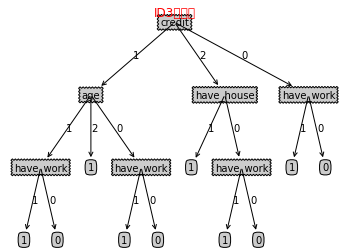

测试结果>>>>>>>>>
ID3_TestSet_classifyResult:
 ['0', '1', '1', '0', '1', '0', '0']
---------------------------------------------


In [273]:
# 创建基于ID3的决策树
fileName = './data/dataset.txt'
fileNameTest = './data/testset.txt'
dataMat, labels = readTrainData(fileName)
print("Entropy is: ", calEntropy(dataMat))
print("-----------------------")
print(u"ID3算法的最优特征索引为:"+str(ID3_chooseBestFeatureToSplit(dataMat)))
print("创建决策树>>>>>>>>>")
#while(True):
labels_tmp = labels[:] # 拷贝，createTree会改变labels
ID3desicionTree = ID3_createTree(dataMat,labels_tmp)
treePlotter.ID3_Tree(ID3desicionTree)
testSet = readTestData(fileNameTest)
print("测试结果>>>>>>>>>")
print('ID3_TestSet_classifyResult:\n', inference(ID3desicionTree, labels, testSet))
print("---------------------------------------------")

Entropy is:  0.9886994082884974
-----------------------
C4.5中第0个特征的信息增益率为：0.024
C4.5中第1个特征的信息增益率为：0.378
C4.5中第2个特征的信息增益率为：0.459
C4.5中第3个特征的信息增益率为：0.122
C4.5算法的最优特征索引为:2
创建决策树>>>>>>>>>
C4.5中第0个特征的信息增益率为：0.024
C4.5中第1个特征的信息增益率为：0.378
C4.5中第2个特征的信息增益率为：0.459
C4.5中第3个特征的信息增益率为：0.122
此时最优索引为：have_house
C4.5中第0个特征的信息增益率为：0.103
C4.5中第1个特征的信息增益率为：1.000
C4.5中第2个特征的信息增益率为：0.185
此时最优索引为：have_work


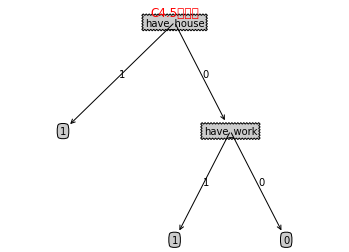

测试结果>>>>>>>>>
C4.5_TestSet_classifyResult:
 ['0', '1', '1', '0', '1', '0', '0']
---------------------------------------------


In [274]:
# 创建基于C4.5的决策树
fileName = './data/dataset.txt'
fileNameTest = './data/testset.txt'
dataMat, labels = readTrainData(fileName)
print("Entropy is: ", calEntropy(dataMat))
print("-----------------------")
print(u"C4.5算法的最优特征索引为:"+str(C45_chooseBestFeatureToSplit(dataMat)))
print("创建决策树>>>>>>>>>")
#while(True):
labels_tmp = labels[:] # 拷贝，createTree会改变labels
C45desicionTree = C45_createTree(dataMat,labels_tmp)
treePlotter.C45_Tree(C45desicionTree)
testSet = readTestData(fileNameTest)
print("测试结果>>>>>>>>>")
print('C4.5_TestSet_classifyResult:\n', inference(C45desicionTree, labels, testSet))
print("---------------------------------------------")